In [170]:
from importlib import reload  # Python 3.4+
import helper.helper as h
h = reload(h)

length, n = 100, 3
h.length, h.n = length, n

In [171]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 
from operator import itemgetter

## Generate $n$D data

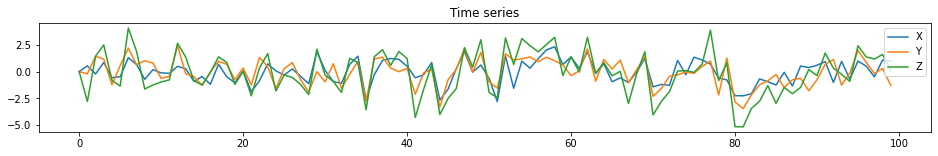

[[1.22259842 0.86268352 1.73723687]
 [0.86268352 1.59144921 2.08394663]
 [1.73723687 2.08394663 4.06947207]]
Actual A:
 [[0.  0.  0. ]
 [0.8 0.  0. ]
 [0.8 0.8 0. ]]

Actual P:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [172]:
# np.random.seed(seed = 1)

## A matrix

# random matrix A
# A = np.tril(np.random.rand(n, n)) # random non-strict LT A
A = h.a_list_to_a_matrix_LT(0.8 * np.ones(int(n * (n + 1) / 2) - n)) # strict LT A with fixed 0.8s

## Permutation matrix
P = np.identity(n) # identity matrix
P = np.array(list(itertools.permutations(np.identity(n)))[np.random.choice(len(list(itertools.permutations(np.identity(n)))))]) # random permutation matrix

# Generate nD data
series = h.generate_sem_data(length, n, A, P)
h.series = series

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

print(np.cov(series.transpose()))
print("Actual A:\n", A)
print("\nActual P:\n", P)

### Cost functions for $n$D
\begin{align*} C_1 &= \left \lVert X - P^{-1}AP X \right \rVert_2^2,\\
C_2 &= \left \lVert X - P^{T}AP X \right \rVert_2^2,\\
C_3 &= \left \lVert X - \frac{P^{T}AP}{\text{det} P} X \right \rVert_2^2. \end{align*}

In [173]:
# convert A to only the parameters
a_list = A[np.tril_indices(n, - 1)]
p_list = np.array([row[:n - 1] for row in P[:n - 1]])

print("C_1(P*, A*):\n", h.C_1(np.append(p_list, a_list)))
print("C_2(P*, A*):\n", h.C_2(np.append(p_list, a_list)))
print("C_3(P*, A*):\n", h.C_3(np.append(p_list, a_list)))

C_1(P*, A*):
 3.0820373778910937
C_2(P*, A*):
 3.0820373778910937
C_3(P*, A*):
 3.0820373778910937


### Constraints for $n$D

In [174]:
a_parms = int(n * (n + 1) / 2 - n)
p_parms = int((n - 1) ** 2)
tot_parms = a_parms + p_parms

# n dimensional constraints
# entries must be between 0 and 1
V = np.identity(tot_parms)[:p_parms,]  # 0 <= p <= 1 for all p

# sum excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    row = np.append(np.zeros((n - 1) * i), np.ones(n - 1))
    row = np.append(row, np.zeros((n - 1 - i - 1) * (n - 1)))
    row = np.append(row, np.zeros(a_parms))   # sum(row(1)) = 1
    V = np.vstack((V, row))
    
# column excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    col = np.append(1, np.zeros(n - 2))
    col = np.tile(col, (n - 1))
    col = np.append(np.zeros(i), col)
    col = np.append(col, np.zeros(a_parms - i))
    V = np.vstack((V, col))
    
# bottom row must sum to one
b_row = np.append(np.ones(p_parms), np.zeros(a_parms))

# create constraints, lower, and upper bounds
V = np.vstack((V, b_row))
L = np.append(np.zeros(p_parms + (n - 1) + (n - 1)), n - 2)
U = np.append(np.ones(p_parms + (n - 1) + (n - 1)), n - 1)

In [183]:
outcome = []

for _ in range(5):
    init_parm = np.random.rand(tot_parms) / n + np.random.rand(tot_parms) / 10
    init_parm[0:4] = [0.49, 0.51, 0.51, 0.49]
    # minimize, starting from a random entry
    results = optimize.minimize(h.C_1, init_parm, constraints = optimize.LinearConstraint(V, L, U)).x

    # get results
    P_DS_out = h.p_list_to_p_matrix(results[:p_parms])
    P_perm_out = h.closest_perm(np.round(h.p_list_to_p_matrix(results[:p_parms]), 2))
    
    A_out = h.a_list_to_a_matrix_LT(results[p_parms:])
    
    B = np.matmul(np.linalg.inv(P), np.matmul(A, P))
    B_out = np.matmul(np.linalg.inv(P_DS_out), np.matmul(A_out, P_DS_out))
    
    print("P_DS:\n", np.round(P_DS_out, 2))
    print("B:\n", np.round(B_out, 3))
    print("B*:\n", B)
    # print(A_out, P_DS_out)
    
    outcome.append([P_perm_out, np.linalg.norm(P_DS_out - P_perm_out, ord='fro'), np.linalg.norm(B_out - B, ord='fro'), h.C_1(results)])
    print("Total cost value:", h.C_1(results))
    
    # print(P_perm_out)
    # print(round(np.linalg.norm(P_DS_out - P_perm_out, ord='fro'), 3))

outcome = sorted(outcome, key=itemgetter(3))

for elem in outcome:
    print("P:", elem[0])
    print("Frob norm of P_DS and P_perm:\n", elem[1])
    print("Frob norm of B and B*:\n", elem[2])

print("\nActual P:\n", P)

P_DS:
 [[0.5  0.5  0.  ]
 [0.5  0.45 0.04]
 [0.   0.04 0.96]]
B:
 [[-0.026  0.095 -0.093]
 [ 0.025 -0.094  0.092]
 [ 0.821  0.676  0.119]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0. ]
 [0.8 0.8 0. ]]
Total cost value: 3.6217649699025265
P_DS:
 [[ 0.5   0.5  -0.  ]
 [ 0.5   0.45  0.05]
 [-0.    0.05  0.95]]
B:
 [[-0.025  0.095 -0.093]
 [ 0.025 -0.094  0.092]
 [ 0.82   0.676  0.119]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0. ]
 [0.8 0.8 0. ]]
Total cost value: 3.6218242419216073
P_DS:
 [[0.5  0.5  0.  ]
 [0.5  0.45 0.05]
 [0.   0.05 0.95]]
B:
 [[-0.025  0.095 -0.093]
 [ 0.025 -0.094  0.092]
 [ 0.82   0.677  0.119]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0. ]
 [0.8 0.8 0. ]]
Total cost value: 3.6218995599445964
P_DS:
 [[0.5  0.5  0.  ]
 [0.5  0.44 0.06]
 [0.   0.06 0.94]]
B:
 [[-0.023  0.096 -0.095]
 [ 0.022 -0.094  0.093]
 [ 0.818  0.683  0.117]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0. ]
 [0.8 0.8 0. ]]
Total cost value: 3.6221622118119328
P_DS:
 [[ 0.5   0.5  -0.  ]
 [ 0.5   0.45  0.05]
 [-0.    0.05  0.95]]
B:
 [[-0.025

In [202]:
a_parms = int(n * (n + 1) / 2 - n)
p_parms = int((n - 1) ** 2)
tot_parms = a_parms + p_parms

# n dimensional constraints
# entries must be between 0 and 1
V = np.identity(tot_parms)[:p_parms,]  # 0 <= p <= 1 for all p

# sum excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    row = np.append(np.zeros((n - 1) * i), np.ones(n - 1))
    row = np.append(row, np.zeros((n - 1 - i - 1) * (n - 1)))
    row = np.append(row, np.zeros(a_parms))   # sum(row(1)) = 1
    V = np.vstack((V, row))
    
# column excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    col = np.append(1, np.zeros(n - 2))
    col = np.tile(col, (n - 1))
    col = np.append(np.zeros(i), col)
    col = np.append(col, np.zeros(a_parms - i))
    V = np.vstack((V, col))
    
# bottom row must sum to one
b_row = np.append(np.ones(p_parms), np.zeros(a_parms))

# create constraints, lower, and upper bounds
V = np.vstack((V, b_row))
L = np.append(np.zeros(p_parms + (n - 1) + (n - 1)), n - 2)
U = np.append(np.ones(p_parms + (n - 1) + (n - 1)), n - 1)

np.random.seed(seed = 1)

outcome = []

for _ in range(3):
    # minimize, starting from a random entry
    results = optimize.minimize(C_nd_3, np.ones(tot_parms) / n + np.random.rand(tot_parms) / n, constraints = optimize.LinearConstraint(V, L, U)).x

    # get results
    P_DS_out = p_list_to_p_matrix(results[:p_parms])
    P_perm_out = closest_perm_1(np.round(p_list_to_p_matrix(results[:p_parms]), 2))
    
    A_out = a_list_to_a_matrix_LT(results[p_parms:])
    
    print(A_out)
    print(np.round(P_DS_out, 2))
    print("B:\n", np.round(np.matmul(np.linalg.inv(P_DS_out), np.matmul(A_out, P_DS_out)), 3))
    print("B*:\n", np.matmul(np.linalg.inv(P), np.matmul(A, P)))
    # print(A_out, P_DS_out)
    
    outcome.append([P_perm_out, np.linalg.norm(P_DS_out - P_perm_out, ord='fro')])
    print("Total cost value:", C_nd_3(results))
    
    print(P_perm_out)
    # print(round(np.linalg.norm(P_DS_out - P_perm_out, ord='fro'), 3))

outcome = sorted(outcome, key=itemgetter(1))

for elem in outcome:
    print("P:", elem[0])
    print("Cost:\n", elem[1])

print("\nActual P:\n", P)

[[ 0.          0.          0.        ]
 [ 0.07926901  0.          0.        ]
 [-0.0734512   0.01554109  0.        ]]
[[0.09 0.91 0.  ]
 [0.43 0.09 0.48]
 [0.48 0.   0.52]]
B:
 [[-0.513 -8.84   0.455]
 [ 0.053  0.914 -0.047]
 [ 0.467  7.933 -0.401]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0.8]
 [0.8 0.  0. ]]
Total cost value: 0.47439272638156266
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[ 0.          0.          0.        ]
 [-0.00031775  0.          0.        ]
 [ 0.00325179 -0.0033231   0.        ]]
[[0.2  0.52 0.28]
 [0.23 0.48 0.29]
 [0.57 0.   0.43]]
B:
 [[-0.109 -0.323 -0.163]
 [-0.036 -0.107 -0.054]
 [ 0.145  0.43   0.216]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0.8]
 [0.8 0.  0. ]]
Total cost value: 0.5883881717141666
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[ 0.          0.          0.        ]
 [-0.00146557  0.          0.        ]
 [-0.05111359  0.05065225  0.        ]]
[[0.2  0.49 0.31]
 [0.19 0.51 0.31]
 [0.61 0.   0.39]]
B:
 [[-0.101 -0.238 -0.153]
 [-0.059 -0.142 -0.091]
 [ 0.159  0.38   0.243]]

### All required constraints in 3D

## Generate a Doubly Stochastic Matrix

In [10]:
def gen_P(n):
    P = np.random.random((n, n))
    rsum, csum = 0, 0

    # Sinkhorn balancing from a random matrix
    while (np.any(np.round(rsum, 3) != 1)) | (np.any(np.round(csum, 3) != 1)):
        P /= P.sum(0)
        P = P / P.sum(1)[:, np.newaxis]
        rsum = P.sum(1)
        csum = P.sum(0)
        
    return P

In [141]:
Sigma = np.identity(n)

def expected_cost(A, P, As, Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

def expected_cost(B, Bs):
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    print(covariance_X)
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

B = np.array([[0, 0.451], [0., 0.]])
Bs = np.array([[0, 0], [0.6, 0.0]])

print(expected_cost(B, Bs))

[[1.   0.  ]
 [0.   1.36]]
2.63662536


In [138]:
def B_cost(B):
    cost = 0

    for t in range(length):
        val = series[t]
        est = np.matmul(B, series[t])
        cost += np.linalg.norm(val - est, ord = 2) ** 2

    return cost / (length - 1) # regularization

A = np.array([[0, 0], [0.451, 0]])
P = np.array([[0, 1], [1, 0]])
B = np.array([[0, 0.447], [0., 0.]])
print(B_cost(B))
print(h.C_1(np.array([0, 0.447])))

2.1106503201039564
2.1106503201039564


In [142]:
P_inv = np.linalg.inv(P)
B = np.matmul(P_inv, np.matmul(A, P))
print(B)
print(B_cost(B))
print(h.C_1(np.array([0, 0.451])))

[[0.    0.451]
 [0.    0.   ]]
2.110899179052005
2.110899179052005
